In [112]:
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import re
from wmfdata import hive, charting
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import pct_str

%matplotlib inline
charting.set_mpl_style()

# Getting a list of participants into Hive

In [69]:
campaigns_html = requests.get("https://dashboard.wikiedu.org/campaigns").text
soup = BeautifulSoup(campaigns_html, "lxml")
campaign_urls = [tag.get("href") for tag in soup.select("td.title + td > a")]
campaign_csvs = ["https://dashboard.wikiedu.org" + slug for slug in campaign_urls]

# Have to remove visiting scholars since they are already experienced Wikimedians
campaign_csvs = [url for url in filter(lambda url: not re.search("visiting_scholars", url), campaign_csvs)]

rosters = []
for csv in campaign_csvs:
    rows = requests.get(csv).text.split("\n")
    rows.pop() # Remove empty last line
    rosters.append(pd.Series(rows))

In [71]:
participants = pd.concat(rosters, ignore_index=True)

In [76]:
filepath = "../data/wiki-education-foundation-participants.csv"
participants.to_csv(filepath, index=False)
hive.load_csv(
    filepath,
    field_spec="user_name string",
    db_name="neilpquinn",
    table_name="wiki_education_foundation_participants",
)

log4j:WARN No such property [maxBackupIndex] in org.apache.log4j.DailyRollingFileAppender.

Logging initialized using configuration in file:/etc/hive/conf.analytics-hadoop/hive-log4j.properties
Loading data to table neilpquinn.wiki_education_foundation_participants
OK
Time taken: 1.596 seconds



# New active editors

In [23]:
def bin_wikigroup(ser):
    enwiki = (ser == "enwiki")
    other = (ser != "enwiki")
    
    return pd.Categorical(
        ser
        .mask(enwiki, "enwiki")
        .mask(other, "other")
    )

new_active_editors_r = hive.run("""
select
    cohort,
    wiki,
    sum(cast(wefp.user_name is not null as int)) as wef_new_users,
    sum(cast(wefp.user_name is null as int)) as non_wef_new_users
from neilpquinn.new_editors ne
left join neilpquinn.wiki_education_foundation_participants wefp
on ne.user_name = wefp.user_name
where 1st_month_edits >= 5
group by cohort, wiki
"""
)

new_active_editors = (
    new_active_editors_r
    .assign(
        cohort=lambda df: pd.to_datetime(df["cohort"]),
        wikigroup=lambda df: bin_wikigroup(df["wiki"])
    )
)

In [30]:
(new_active_editors
.query("cohort >= '2017-11-01'")
.groupby("wikigroup").agg({
    "wef_new_users": "sum",
    "non_wef_new_users": "sum"
}))

,non_wef_new_users,wef_new_users
wikigroup,,
enwiki,89806,21358
other,117679,6


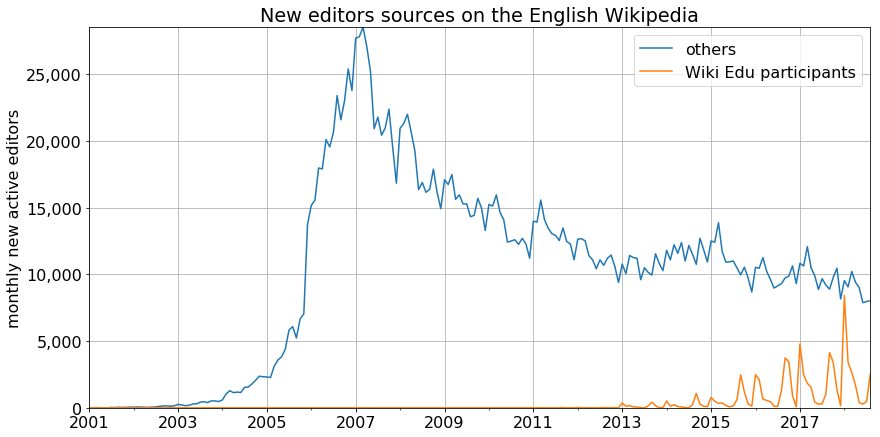

In [144]:
global_new_active_editors = new_active_editors.query("wikigroup == 'enwiki'").groupby("cohort").sum().iloc[:, [1, 0]]
global_new_active_editors.columns = ["others", "Wiki Edu participants"]
ax = global_new_active_editors.plot()
ax.set_ylabel("monthly new active editors")
ax.set_xlabel("")
ax.set_title("New editors sources on the English Wikipedia")
ax.yaxis.set_major_formatter(comma_fmt);

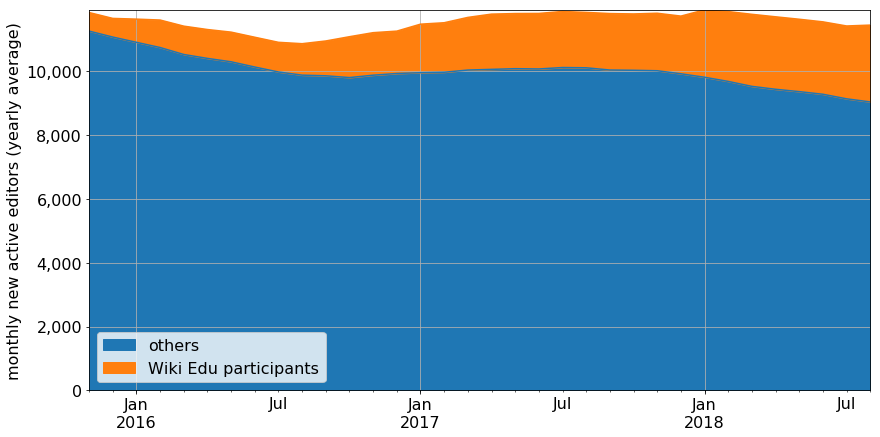

In [145]:
ax = global_new_active_editors.rolling(12).mean()["2015-11":].plot.area()
ax.set_ylabel("monthly new active editors (yearly average)")
ax.set_xlabel("")
ax.set_title("Yearly")
ax.yaxis.set_major_formatter(comma_fmt);

# English Wikipedia second-month new editor retention

In [43]:
new_editor_retention_r = hive.run("""
select
    cohort,
    if(wefp.user_name is null, "non_wef_participants", "wef_participants") as type,
    sum(cast(2nd_month_edits >= 1 as int)) / sum(cast(1st_month_edits >= 1 as int)) as new_user_retention
from neilpquinn.new_editors ne
left join neilpquinn.wiki_education_foundation_participants wefp
on ne.user_name = wefp.user_name
where wiki = "enwiki"
group by cohort, wefp.user_name is null
""")

In [44]:
new_editor_retention = (
    new_editor_retention_r
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
    .set_index(["cohort", "type"])
    .unstack()
    .fillna(0)
)

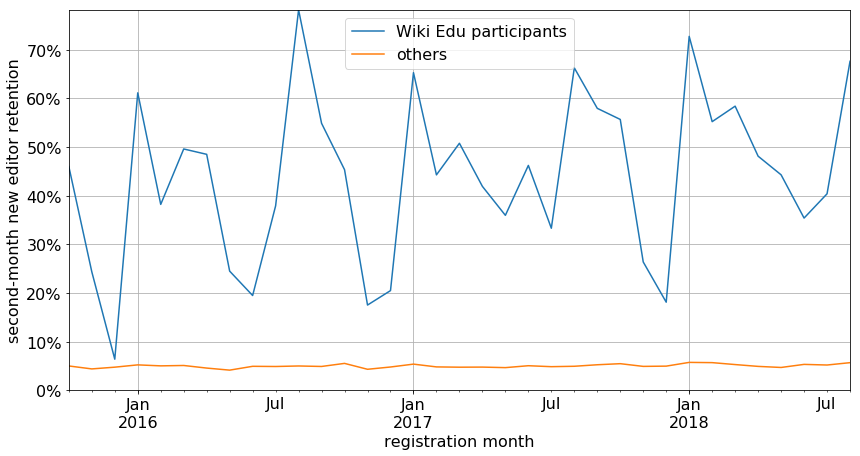

In [129]:
recent_retention = new_editor_retention["2015-10":].iloc[:, [1, 0]]
recent_retention.columns = ["Wiki Edu participants", "others"]

ax = recent_retention.plot()
plt.ylim(0)
ax.set_ylabel("second-month new editor retention")
ax.set_xlabel("registration month")
ax.yaxis.set_major_formatter(pct_fmt);

# English Wikipedia sixth-month new editor retention

In [72]:
enwiki_new_eds_r = hive.run("""
select
    ne.user_name as user_name,
    cohort,
    if(wefp.user_name is null, "non_wef", "wef") as type,
    1st_month_edits as 1st_mo_edits,
    2nd_month_edits as 2nd_mo_edits,
    sum(cast(mwh.event_user_text is not null as int)) as 6th_mo_edits
from neilpquinn.new_editors ne
left join neilpquinn.wiki_education_foundation_participants wefp
on ne.user_name = wefp.user_name
left join wmf.mediawiki_history mwh
on
    ne.user_name = event_user_text and
    event_timestamp between 
        date_add(event_user_creation_timestamp, 150) and
        date_add(event_user_creation_timestamp, 180) and
    mwh.wiki_db = "enwiki" and
    snapshot = "2018-10"
where 
    cohort between "2017-05" and "2018-05" and
    ne.wiki = "enwiki"
group by ne.user_name, cohort, wefp.user_name, 1st_month_edits, 2nd_month_edits
""")

In [75]:
enwiki_new_eds = enwiki_new_eds_r.copy()

In [80]:
enwiki_new_eds.groupby("type").apply(lambda grp: sum(grp["6th_mo_edits"] > 0) / len(grp)).map(pct_str)

type
non_wef    2.1%
wef        1.0%
dtype: object

In [107]:
(enwiki_new_eds
.drop(["user_name", "cohort"], axis=1)
.groupby("type")
.agg(lambda grp: sum(grp > 0))
)

,1st_mo_edits,2nd_mo_edits,6th_mo_edits
type,,,
non_wef,609491,31287,12522
wef,15192,8363,150


(0, 250)

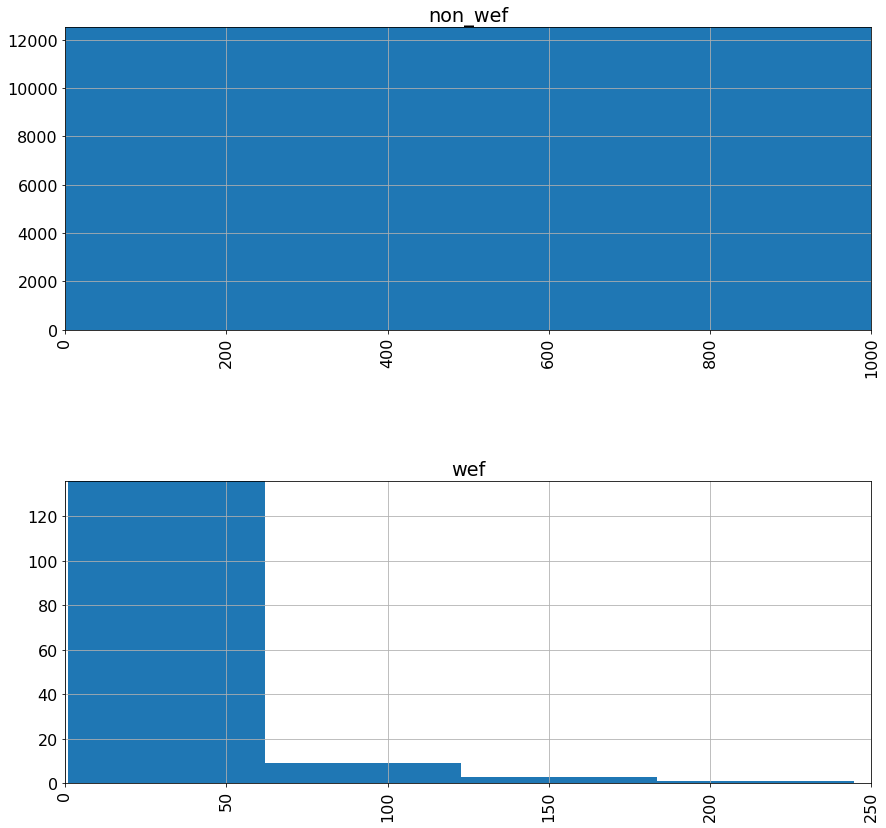

In [100]:
sixth_mo_eds = enwiki_new_eds[lambda x: x["6th_mo_edits"] > 0]
ax1, ax2 = sixth_mo_eds.hist(column="6th_mo_edits", by="type", layout=(2, 1), figsize=(14, 14))
ax1.set_xlim(0, 1000)
ax2.set_xlim(0, 250)